# Code for generating Figure 4 and SFig 3 panels from derivative data


Code to compute dimensionality using the participation ratio of RSMs is here: `python analysis1_compute_regional_RDMs.py`

Code to compute multi-task decodability is here: `python analysis3_regional_decodability.py --decoder 'cosine'`

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In [2]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

#### Set up basic parameters

In [3]:
figuredir = '../figures/Fig4/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Load multi-task representational dimensionality and margulies gradients

In [5]:
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality.csv')
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)


# Gradient 1

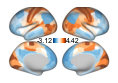

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

newcmp = ListedColormap(newcolors[::-1], name='OrangeBlue')

parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')
i = 0
if not os.path.exists(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '.png'):
    tmp = np.hstack((parcellated_gradients[180:,i],parcellated_gradients[:180,i]))
    vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '.png',tmp,vrange=(-vrange, vrange),cmap=newcmp)


plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(111)
im = img.imread(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '.png') 
#     im = img.imread(figuredir + 'Parcellated_TaskDimensionality_' + rsm_matrix + '.png') 
plt.imshow(im)
plt.axis('off')
#
vmin, vmax = np.min(parcellated_gradients[:,i]), np.max(parcellated_gradients[:,i])
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
#
plt.imshow(im)
plt.axis('off')
# plt.title('Unimodal–transmodal\nRSFC gradient 1',fontsize=10)
plt.tight_layout()
plt.savefig(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '_cmap.png',dpi=300)

# Myelin map

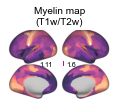

In [11]:
myelin_map_64k = np.loadtxt('../processed_data/MyelinMapParcellated_v1.csv',delimiter=',')
myelin_map = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    myelin_map[roi] = np.mean(myelin_map_64k[roi_ind])
if not os.path.exists(figuredir + 'Parcellated_MyelinMap.png'):
    tmp = np.hstack((myelin_map[180:],myelin_map[:180]))
#     tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'Parcellated_MyelinMap.png',tmp,cmap='magma')
    

####
plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(111)
im = img.imread(figuredir + 'Parcellated_MyelinMap.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Myelin map\n(T1w/T2w)',fontsize=10,fontname='Arial')
#
vmin, vmax = np.min(myelin_map), np.max(myelin_map)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
#
plt.tight_layout()
plt.savefig(figuredir + 'Parcellated_MyelinMap_cmap.png',dpi=300)

# Representational dimensionality panel

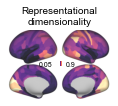

In [15]:
if not os.path.exists(figuredir + 'Parcellated_TaskDimensionality_cosine.png'):
    tmp = np.hstack((avg_dim[180:],avg_dim[:180]))
#     tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'Parcellated_TaskDimensionality_cosine.png',tmp,cmap='magma')

####
plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(111)
im = img.imread(figuredir + 'Parcellated_TaskDimensionality_cosine.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Representational\ndimensionality',fontsize=10,fontname='Arial')
#
vmin, vmax = np.min(avg_dim), np.max(avg_dim)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
#
plt.tight_layout()
plt.savefig(figuredir + 'Parcellated_TaskDimensionality_cosine_cmp.png',dpi=300)





# Multi-task decoding panel

Correlation between decoding and rep dim: rho = 0.9378665758879934 | p = 1.2262777752701216e-166


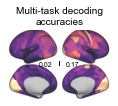

In [19]:
decod = 'cosine'
## Load data
parcel_decoding = {}

h5f = h5py.File('../processed_data/analysis3/analysis3_decoding_cosine_allsubjs.h5','r')
tmp = h5f['data'][:]
parcel_decoding[decod] = np.mean(tmp,axis=0)
h5f.close()
    
if not os.path.exists(figuredir + 'Parcellated_TaskDecoding_cosine.png'):
    tmp = np.hstack((parcel_decoding[decod][180:],parcel_decoding[decod][:180]))
    wbplot.pscalar(figuredir + 'Parcellated_TaskDecoding_cosine.png',tmp,cmap='magma')
        
    
plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
decod = 'cosine'
im = img.imread(figuredir + 'Parcellated_TaskDecoding_' + decod + '.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Multi-task decoding\naccuracies',fontsize=10)
#
vmin, vmax = np.min(parcel_decoding[decod]), np.max(parcel_decoding[decod])
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');

plt.tight_layout()

rho, p = stats.pearsonr(parcel_decoding[decod], avg_dim)
print('Correlation between decoding and rep dim: rho =', rho, '| p =', p)
plt.savefig(figuredir + 'MultiTaskDecodingMap.png',dpi=300)

# Brain smash multi-task decoding and rep dim

In [25]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
n_surrogates = 1000
geo_dist_rh = np.loadtxt('../processed_data/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt('../processed_data/LeftParcelGeodesicDistmat.txt')
base = Base(avg_dim[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(avg_dim[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_dim = np.hstack((surrogates_lh,surrogates_rh))

In [26]:
surrogate_brainmap_corrs = pearsonr(surrogates_dim,parcel_decoding[decod]).flatten()
test_stat = stats.pearsonr(avg_dim,parcel_decoding[decod])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between decoding and rep dim: r =', r, '| p =', p)


Correlation between decoding and rep dim: r = 0.9378665758879927 | p = 0.0


# Plot scatter plots

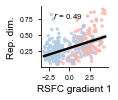

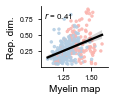

In [21]:
plt.figure(figsize=(1.7,1.5))
sns.regplot(x=parcellated_gradients[:,0],y=avg_dim,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('Rep. dim.',fontsize=10)
plt.xlabel('RSFC gradient 1',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([-3.5,4.75])
rho, p = stats.pearsonr(parcellated_gradients[:,0],avg_dim)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.18,0.8),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'ScatterPlot_DimensionalityXGradient1.pdf',transparent=True)

#
#
plt.figure(figsize=(1.7,1.5))
ax = sns.regplot(x=myelin_map,y=avg_dim,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('Rep. dim.',fontsize=10)
plt.xlabel('Myelin map',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
# plt.yticks([0.25,.5,.75],['','',''])
plt.yticks(fontsize=7)
plt.xlim([1.05,1.65])
rho, p = stats.pearsonr(myelin_map,avg_dim)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.05,.8),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'ScatterPlot_DimensionalityXMyelin.pdf',transparent=True)

region_seg = np.loadtxt('../processed_data/ra_segregation.txt')


# Brain smash for Dim X RSFC grad and Myelin Map

In [32]:
surrogate_brainmap_corrs = pearsonr(surrogates_dim,parcellated_gradients[:,0]).flatten()
test_stat = stats.pearsonr(avg_dim,parcellated_gradients[:,0])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and RSFC Grad 1: r =', r, '| p =', p)

surrogate_brainmap_corrs = pearsonr(surrogates_dim,myelin_map).flatten()
test_stat = stats.pearsonr(avg_dim,myelin_map)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and Myelin map: r =', r, '| p =', p)


Correlation between rep dim and RSFC Grad 1: r = 0.48776894400319615 | p = 0.0
Correlation between rep dim and Myelin map: r = 0.40964529336112343 | p = 0.0


# Compute dimensionality of transmodal versus unimodal regions

Unimodal vs. Transmodal dimensionality: t = 6.654720803644902 | p = 1.0666385311004161e-10


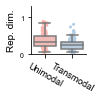

In [23]:
df_dim_avg = df_dim.groupby(['Parcels','Network']).mean().reset_index()

df_system = {}
df_system['Dimensionality'] = []
df_system['System'] = []
for parcel in df_dim_avg.Parcels.values:
    tmpdf = df_dim_avg.loc[df_dim_avg.Parcels==parcel]
    if tmpdf.Network.values[0] in ['VIS1', 'VIS2', 'SMN', 'AUD']:
        df_system['Dimensionality'].append(tmpdf.Dimensionality.values[0])
        df_system['System'].append('Unimodal')
    else:
        df_system['Dimensionality'].append(tmpdf.Dimensionality.values[0])
        df_system['System'].append('Transmodal')
df_system = pd.DataFrame(df_system)

plt.figure(figsize=(1.5,1.5))
sns.stripplot(x="System",y="Dimensionality",data=df_system,dodge=True,size=3,palette=[color2, color1],zorder=0)
ax = sns.boxplot(x="System",y="Dimensionality",data=df_system,sym='',whis=[2.5,97.5],palette=[color2,color1]) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=-30,fontsize=9);
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None);
plt.ylabel('Rep. dim.',fontsize=10);
plt.yticks(fontsize=7)
plt.ylim([0,1.3])
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'Boxplot_DimensionalityVsSystem.pdf')

t, p = stats.ttest_ind(df_system.loc[df_system.System=='Unimodal'].Dimensionality.values,df_system.loc[df_system.System=='Transmodal'].Dimensionality.values)
print("Unimodal vs. Transmodal dimensionality: t =", t, "| p =", p)

___

# Supplementary analyses

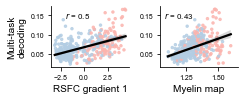

In [31]:
# plt.figure(figsize=(2.5,1.25))
plt.figure(figsize=(3.5,1.5))
# fig, ax = plt.subplots(figsize=(6, 3))
plt.subplot(1,2,1)
# sns.regplot(x=parcellated_gradients[:,0],y=avg_dim,color='k',fit_reg=False)
sns.regplot(x=parcellated_gradients[:,0],y=parcel_decoding[decod],color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('Multi-task\ndecoding',fontsize=10)
plt.xlabel('RSFC gradient 1',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([-3.5,4.75])
rho, p = stats.pearsonr(parcellated_gradients[:,0],parcel_decoding[decod])
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.18,0.8),fontsize=8,xycoords='axes fraction')

#
#
# plt.figure(figsize=(1.25,1.25))
ax = plt.subplot(1,2,2)

# sns.regplot(x=myelin_map,y=avg_dim,color='k',fit_reg=False)
ax = sns.regplot(x=myelin_map,y=parcel_decoding[decod],color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
# plt.ylabel('Dim.',fontsize=10)
plt.xlabel('Myelin map',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
# plt.yticks([0.25,.5,.75],['','',''])
plt.yticks(fontsize=7)
plt.xlim([1.05,1.65])
rho, p = stats.pearsonr(myelin_map,parcel_decoding[decod])
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.05,.8),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + '../SFig_Decodability/ScatterPlot_DecodabilityXMyelinAndGradient1.pdf',transparent=True)


In [13]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
n_surrogates = 1000
geo_dist_rh = np.loadtxt('../../derivatives/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt('../../derivatives/LeftParcelGeodesicDistmat.txt')
base = Base(parcel_decoding[decod][:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(parcel_decoding[decod][180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_dec = np.hstack((surrogates_lh,surrogates_rh))

In [14]:
surrogate_brainmap_corrs = pearsonr(surrogates_dec,parcellated_gradients[:,0]).flatten()
test_stat = stats.pearsonr(parcel_decoding[decod],parcellated_gradients[:,0])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and RSFC Grad 1: r =', r, '| p =', p)

surrogate_brainmap_corrs = pearsonr(surrogates_dec,myelin_map).flatten()
test_stat = stats.pearsonr(parcel_decoding[decod],myelin_map)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and Myelin map: r =', r, '| p =', p)


Correlation between rep dim and RSFC Grad 1: r = 0.5030782037551685 | p = 0.0
Correlation between rep dim and Myelin map: r = 0.43334010304638726 | p = 0.0


# Correct for parcel size -- representational dimensionality

In [14]:
from sklearn.linear_model import LinearRegression

parcel_size = []
for roi in range(nParcels):
    parcel_size.append(len(np.where(glasser==roi+1)[0]))
parcel_size = np.asarray(parcel_size)

X = parcel_size.copy()
X.shape = (len(X),1)
y = avg_dim.copy()
y.shape = (len(y),1)
LinReg = LinearRegression()
LinReg.fit(X,y)

resid_avgdim = y - LinReg.predict(X)
resid_avgdim = resid_avgdim.reshape(-1)

r, p = stats.pearsonr(parcel_size, avg_dim)
print('Correlation between parcel size and representational dimensionality | r =', r, '| p=', p)

Correlation between parcel size and representational dimensionality | r = 0.4394788177934562 | p= 1.9659541027604145e-18


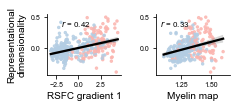

In [32]:
# plt.figure(figsize=(2.5,1.25))
plt.figure(figsize=(3.5,1.5))
# fig, ax = plt.subplots(figsize=(6, 3))
plt.subplot(1,2,1)
# sns.regplot(x=parcellated_gradients[:,0],y=avg_dim,color='k',fit_reg=False)
sns.regplot(x=parcellated_gradients[:,0],y=resid_avgdim,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('Representational\ndimensionality',fontsize=10)
plt.xlabel('RSFC gradient 1',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([-3.5,4.75])
rho, p = stats.pearsonr(parcellated_gradients[:,0],resid_avgdim)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.18,0.8),fontsize=8,xycoords='axes fraction')

#
#
# plt.figure(figsize=(1.25,1.25))
ax = plt.subplot(1,2,2)

# sns.regplot(x=myelin_map,y=avg_dim,color='k',fit_reg=False)
ax = sns.regplot(x=myelin_map,y=resid_avgdim,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
# plt.ylabel('Dim.',fontsize=10)
plt.xlabel('Myelin map',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
# plt.yticks([0.25,.5,.75],['','',''])
plt.yticks(fontsize=7)
plt.xlim([1.05,1.65])
rho, p = stats.pearsonr(myelin_map,resid_avgdim)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.05,.8),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + '../SFig_Decodability/ScatterPlot_RepDimXMyelinAndGradient1_RemoveParcelSizeCovariate.pdf',transparent=True)


In [34]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
n_surrogates = 1000
geo_dist_rh = np.loadtxt('../../derivatives/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt('../../derivatives/LeftParcelGeodesicDistmat.txt')
base = Base(resid_avgdim[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(resid_avgdim[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_dim_control = np.hstack((surrogates_lh,surrogates_rh))

In [35]:
surrogate_brainmap_corrs = pearsonr(surrogates_dim_control,parcellated_gradients[:,0]).flatten()
test_stat = stats.pearsonr(resid_avgdim,parcellated_gradients[:,0])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and RSFC Grad 1: r =', r, '| p =', p)

surrogate_brainmap_corrs = pearsonr(surrogates_dim_control,myelin_map).flatten()
test_stat = stats.pearsonr(resid_avgdim,myelin_map)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and Myelin map: r =', r, '| p =', p)


Correlation between rep dim and RSFC Grad 1: r = 0.4226057529807609 | p = 0.0
Correlation between rep dim and Myelin map: r = 0.33158757541196443 | p = 0.0


# Correct for parcel size -- multi-task decoding

In [16]:
from sklearn.linear_model import LinearRegression

parcel_size = []
for roi in range(nParcels):
    parcel_size.append(len(np.where(glasser==roi+1)[0]))
parcel_size = np.asarray(parcel_size)

X = parcel_size.copy()
X.shape = (len(X),1)
y = parcel_decoding[decod].copy()
y.shape = (len(y),1)
LinReg = LinearRegression()
LinReg.fit(X,y)

resid_dec = y - LinReg.predict(X)
resid_dec = resid_dec.reshape(-1)


r, p = stats.pearsonr(parcel_size, parcel_decoding[decod])
print('Correlation between parcel size and representational dimensionality | r =', r, '| p=', p)

Correlation between parcel size and representational dimensionality | r = 0.45170247747930226 | p= 1.679830236536494e-19


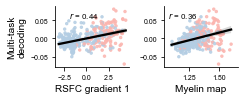

In [33]:
# plt.figure(figsize=(2.5,1.25))
plt.figure(figsize=(3.5,1.5))
# fig, ax = plt.subplots(figsize=(6, 3))
plt.subplot(1,2,1)
# sns.regplot(x=parcellated_gradients[:,0],y=avg_dim,color='k',fit_reg=False)
sns.regplot(x=parcellated_gradients[:,0],y=resid_dec,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('Multi-task\ndecoding',fontsize=10)
plt.xlabel('RSFC gradient 1',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([-3.5,4.75])
rho, p = stats.pearsonr(parcellated_gradients[:,0],resid_dec)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.18,0.8),fontsize=8,xycoords='axes fraction')

#
#
# plt.figure(figsize=(1.25,1.25))
ax = plt.subplot(1,2,2)

# sns.regplot(x=myelin_map,y=avg_dim,color='k',fit_reg=False)
ax = sns.regplot(x=myelin_map,y=resid_dec,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
# plt.ylabel('Dim.',fontsize=10)
plt.xlabel('Myelin map',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
# plt.yticks([0.25,.5,.75],['','',''])
plt.yticks(fontsize=7)
plt.xlim([1.05,1.65])
rho, p = stats.pearsonr(myelin_map,resid_dec)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.05,.8),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()

# plt.savefig(figuredir + '../SFig_Decodability/ScatterPlot_DecodingXMyelinAndGradient1_RemoveParcelSizeCovariate.pdf',transparent=True)


In [53]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
n_surrogates = 1000
geo_dist_rh = np.loadtxt('../../derivatives/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt('../../derivatives/LeftParcelGeodesicDistmat.txt')
base = Base(resid_dec[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(resid_dec[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_dec_control = np.hstack((surrogates_lh,surrogates_rh))

In [35]:
surrogate_brainmap_corrs = pearsonr(surrogates_dec_control,parcellated_gradients[:,0]).flatten()
test_stat = stats.pearsonr(resid_dec,parcellated_gradients[:,0])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and RSFC Grad 1: r =', r, '| p =', p)

surrogate_brainmap_corrs = pearsonr(surrogates_dec_control,myelin_map).flatten()
test_stat = stats.pearsonr(resid_dec,myelin_map)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between rep dim and Myelin map: r =', r, '| p =', p)


Correlation between rep dim and RSFC Grad 1: r = 0.4226057529807609 | p = 0.0
Correlation between rep dim and Myelin map: r = 0.33158757541196443 | p = 0.0
